In [65]:
import numpy as np

In [66]:
import pandas as pd

In [67]:
data = pd.read_csv('dataset_ner_rus.txt', sep=" ")

In [70]:
data = data.fillna(method="ffill")

In [68]:
data.head(15)

,Sentence: #,Word,Tag
0,1.0,25,B-DATE
1,1.0,апреля,I-DATE
2,1.0,Владимир,B-PERSON
3,1.0,Петров,I-PERSON
4,1.0,выступил,O
5,1.0,на,O
6,1.0,открытии,O
7,1.0,компании,O
8,1.0,"""Северный",B-ORG
9,1.0,"край""",I-ORG


In [71]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [72]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

У нас 47959 предложений, содержащих 35179 различных слов с 17 различными тегами. Мы используем SentenceGetter class для того, чтобы получить отдельно преложения по их номерам.

In [73]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [74]:
getter = SentenceGetter(data)


In [75]:
sent = getter.get_next()

In [77]:
sentences = getter.sentences

### Подготовка данных
Введём словарь по словам и тегам

In [78]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [79]:
word2idx["Владимир"]

35150

In [80]:
tag2idx["B-LOC"]

8

Представим слова и теги в векторном виде

In [81]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [82]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [83]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [84]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Теги приведём к категориальному типу.

In [85]:
from keras.utils import to_categorical

In [86]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

Разделим данные на тренировочное и тестовое множества

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

### Bi-LSTM + CRF

In [89]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [90]:
from keras_contrib.layers import CRF

In [91]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  #  biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # dense layer
crf = CRF(n_tags)  # CRF layer

In [92]:
out = crf(model)   # output

In [93]:
model = Model(input, out)

In [94]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

C:\ProgramData\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\ProgramData\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 122s 3ms/step - loss: 0.1158 - crf_viterbi_accuracy: 0.9683 - val_loss: 0.0449 - val_crf_viterbi_accuracy: 0.9848
Epoch 2/10
38846/38846 [==============================] - 123s 3ms/step - loss: 0.0332 - crf_viterbi_accuracy: 0.9879 - val_loss: 0.0302 - val_crf_viterbi_accuracy: 0.9879
Epoch 3/10
38846/38846 [==============================] - 125s 3ms/step - loss: 0.0243 - crf_viterbi_accuracy: 0.9903 - val_loss: 0.0253 - val_crf_viterbi_accuracy: 0.9893
Epoch 4/10
38846/38846 [==============================] - 138s 4ms/step - loss: 0.0211 - crf_viterbi_accuracy: 0.9912 - val_loss: 0.0240 - val_crf_viterbi_accuracy: 0.9899
Epoch 5/10
38846/38846 [==============================] - 127s 3ms/step - loss: 0.0192 - crf_viterbi_accuracy: 0.9918 - val_loss: 0.0233 - val_crf_viterbi_accuracy: 0.9901
Epoch 6/10
38846/38846 [==============================] - 131s 3ms/step - loss: 0.0180 - cr

In [98]:
hist = pd.DataFrame(history.history)

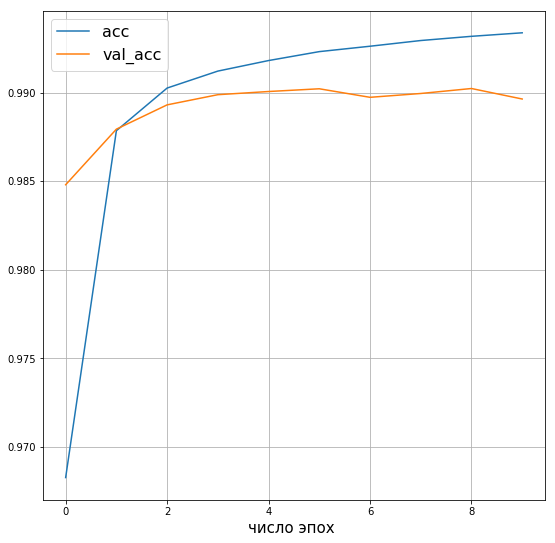

<Figure size 792x792 with 0 Axes>

In [99]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
matplotlib.rcParams["axes.grid"] = True
plt.figure(figsize=(11,11))
ax.plot(hist["crf_viterbi_accuracy"], label = 'acc')
ax.plot(hist["val_crf_viterbi_accuracy"], label = 'val_acc')

#  Добавляем подписи к осям:
ax.set_xlabel('число эпох ',
              fontsize = 15,    #  размер шрифта
              color = 'black',    #  цвет шрифта
              #  параметры области с текстом
        )     #  ширина крайней линии
ax.legend(fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

fig.set_figwidth(9)
fig.set_figheight(9)

### Оценим модель на тестовых данных

In [100]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [101]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 4s 799us/step


In [102]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [103]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.6%


Протестируем на нескольких примерах

In [105]:
i = 5
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
14             : B-DATE B-DATE
декабря        : I-DATE I-DATE
2018           : I-DATE I-DATE
года           : I-DATE I-DATE
постановлено   : O     O
:              : O     O
назначить      : O     O
заместителями  : O     O
администратора : O     O
АС             : B-ORG B-ORG
«              : I-ORG I-ORG
GM             : I-ORG I-ORG
Trading        : I-ORG I-ORG
Analytics      : I-ORG I-ORG
»              : I-ORG I-ORG
(              : O     O
CI01535560     : O     B-ORG
)              : O     O
промышленного  : O     O
стэнда         : O     O
следующих      : O     O
сотрудников    : O     O
:              : O     O
Сорокопудова   : B-PERSON B-PERSON
Сергея         : I-PERSON I-PERSON
Викторовича    : I-PERSON I-PERSON
руководителя   : O     O
направления    : O     O
отдела         : O     O
бизнес         : O     O
-              : O     O
менеджмента    : O     O
и              : O     O
стратегических : O     O
проектов       : O     O
,             

In [107]:
i = 157
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Выручка        : O     O
НЛМК           : B-ORG B-ORG
в              : O     O
2011           : B-DATE B-DATE
году           : I-DATE I-DATE
составила      : O     O
117            : B-MONEY B-MONEY
млрд           : I-MONEY I-MONEY
долларов       : I-MONEY I-MONEY
,              : O     O
рентабельность : O     O
по             : O     O
показателю     : O     O
EBITDA         : O     O
составила      : O     O
195            : B-PERCENT B-PERCENT
%              : I-PERCENT I-PERCENT
.              : O     O


In [109]:
i = 1024
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Петров         : B-PERSON B-PERSON
Владислав      : I-PERSON I-PERSON
Викторович     : I-PERSON I-PERSON
,              : O     O
89165438765    : B-TEL B-TEL
,              : O     O
petrov_vlad@gmail.com: B-EMAIL B-EMAIL
,              : O     O
место          : O     O
пребывания     : О     О
Ленинградская  : B-LOC B-LOC
область        : I-LOC I-LOC
,              : I-LOC O
деревня        : I-LOC O
Бутыга         : I-LOC O
.              : O     O
